## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, Sequential
%matplotlib inline

In [3]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


The data set I am going to use contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the data set are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons.

The two features that haven’t been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the data set.

## Data analysis

In [6]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.shape

(284807, 31)

In [9]:
df.isnull().values.any()  # checking if there is any null values

False

In [21]:
count_classes = df.groupby(['Class']).size()

Text(0, 0.5, 'Frequency')

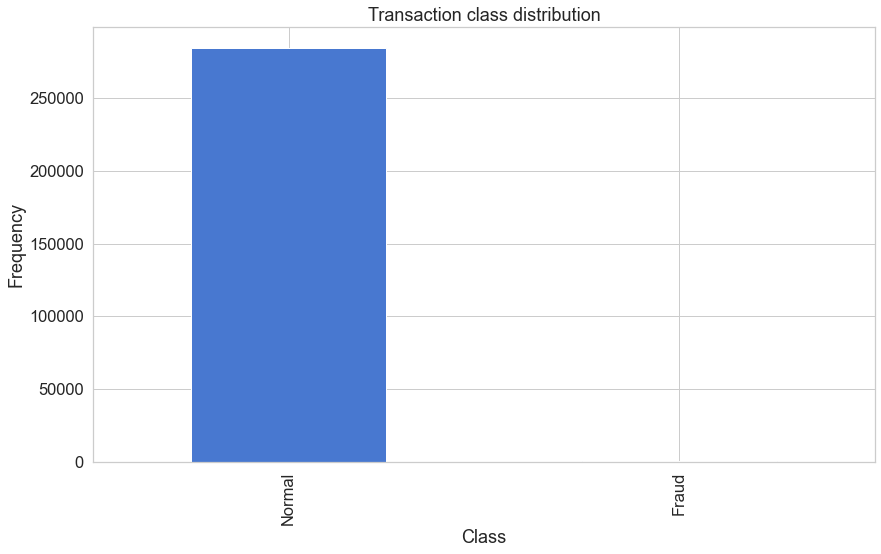

In [26]:
count_classes.plot(kind= 'bar')
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [31]:
frauds = df[df['Class'] == 1]
normal = df[df['Class'] == 0]

In [35]:
frauds.head(3)
frauds.shape

(492, 31)

In [34]:
normal.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [36]:
normal.shape

(284315, 31)

#### Since only 3 of the features (time, amount and Class) are non-anomyzed, let’s explore them.

In [37]:
frauds['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [38]:
normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Text(0.5, 1.0, 'Fraud')

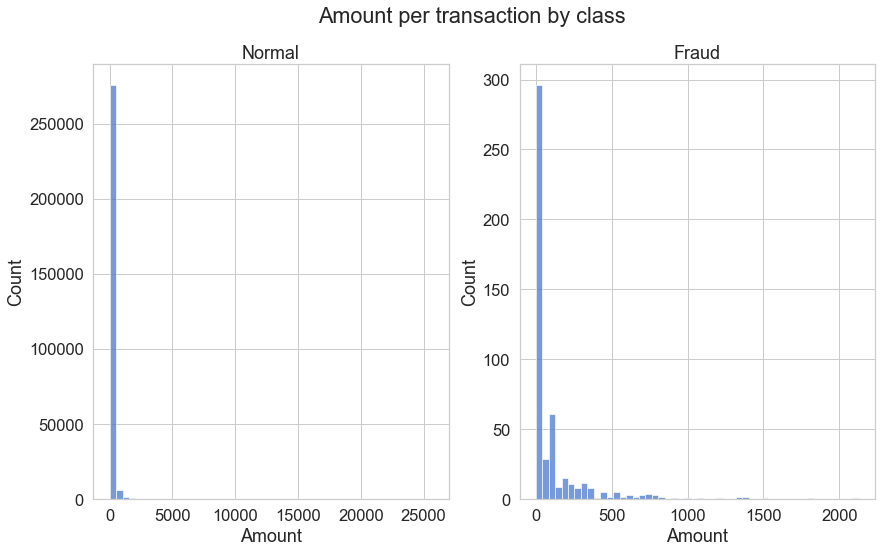

In [54]:
f, axes = plt.subplots(1, 2)
f.suptitle('Amount per transaction by class')
sns.histplot(x= normal['Amount'], data=normal,  ax=axes[0], bins=50)
sns.histplot( x= frauds['Amount'], data=frauds, ax=axes[1], bins=50)
axes[0].set_title('Normal')
axes[1].set_title('Fraud')

Text(0.5, 1.0, 'Fraud')

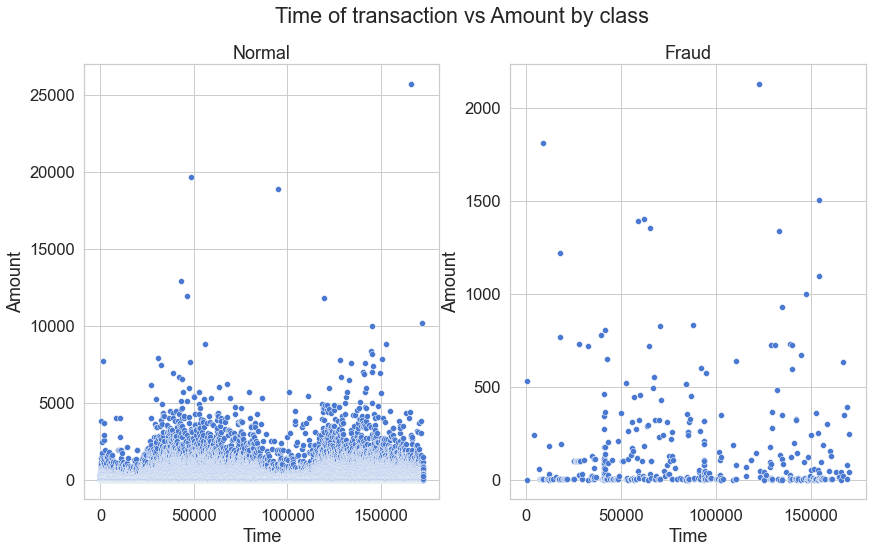

In [55]:
f, axes = plt.subplots(1, 2)
f.suptitle('Time of transaction vs Amount by class')
sns.scatterplot(x= normal['Time'],y= normal['Amount'], data=normal,  ax=axes[0])
sns.scatterplot( x= frauds['Time'],y= frauds['Amount'], data=frauds, ax=axes[1])
axes[0].set_title('Normal')
axes[1].set_title('Fraud')

The time does not seem to be a crucial feature in distinguishing normal vs fraud cases. Hence, I will drop it.

In [56]:
data = df.drop(['Time'], axis=1)

In [57]:
from sklearn.preprocessing import StandardScaler

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

The numerical amount in fraud and normal cases differ highly, hence we scale them.

## Scaling the 'Amount' using StandardScaler

In [58]:
from sklearn.preprocessing import StandardScaler

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

## Building the model
We will be using autoencoders for the fraud detection model. Using autoencoders, we train the database only to learn the representation of the non-fraudulent transactions.

The reason behind applying this method is to let the model learn the best representation of non-fraudulent cases so that it automatically distinguishes the other case from it.

In [76]:
# non_fraud = data[data['Class'] == 0] #.sample(1000)
# fraud = data[data['Class'] == 1]

# df = non_fraud.append(fraud)

In [86]:
# X = df.drop(['Class'], axis = 1).values
# Y = df["Class"].values

## Spiting the data into 80% training and 20% testing

In [108]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

# X_train_fraud = X_train[X_train['Class'] == 1]
# X_train = X_train[X_train['Class'] == 0]

X_train = X_train.drop(['Class'], axis=1)
y_test= X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227845, 29)

## Autoencoder model

In [110]:
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

## Training the credit card fraud detection model

In [111]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

## Scaling the values

In [112]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 [==============================] - 0s 20ms/step - loss: 0.2287 - val_loss: 0.2282
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 0.2282 - val_loss: 0.2277
Epoch 3/10
7/7 [==============================] - 0s 4ms/step - loss: 0.2277 - val_loss: 0.2272
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 0.2272 - val_loss: 0.2267
Epoch 5/10
7/7 [==============================] - 0s 4ms/step - loss: 0.2267 - val_loss: 0.2262
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 0.2261 - val_loss: 0.2257
Epoch 7/10
7/7 [==============================] - 0s 4ms/step - loss: 0.2256 - val_loss: 0.2252
Epoch 8/10
7/7 [==============================] - 0s 4ms/step - loss: 0.2251 - val_loss: 0.2246
Epoch 9/10
7/7 [==============================] - 0s 4ms/step - loss: 0.2246 - val_loss: 0.2241
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 0.2240 - val_loss: 0.2236


## Obtain the Hidden Representation

In [113]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

## Model Prediction

In [114]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

## Getting the representation data

In [115]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

## Train, test, split

In [116]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)

# Credit Card Fraud Detection Prediction model

In [117]:
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       747
         1.0       1.00      0.68      0.81       126

    accuracy                           0.95       873
   macro avg       0.97      0.84      0.89       873
weighted avg       0.96      0.95      0.95       873


Accuracy Score:  0.9541809851088202
